In [276]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shutil import copy

In [277]:
root = '/kaggle/input/guns-object-detection/'
# img_files = os.listdir('/kaggle/input/guns-object-detection/Images')
lbl_files = os.listdir('/kaggle/input/guns-object-detection/Labels')

**VERIFYING DATA**

Here, just verifying the bounding box is appearing properly for a given image.

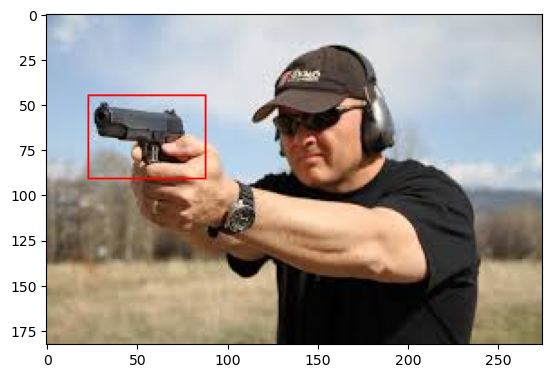

In [278]:
# Randomly picking images and ploting bbox
files = os.listdir(os.path.join(root,'Images'))
rand_num = np.random.randint(1,len(files))
with open(os.path.join(root,'Labels',f'{rand_num}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[1].split(' ')
    f.close()
x1,y1,x2,y2 = int(labels[0]),int(labels[1]),int(labels[2]),int(labels[3])
img = cv2.imread(os.path.join(root,'Images',f'{rand_num}.jpeg'),1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),1)
plt.imshow(img)

**DATA PREPARATION FOR YOLO MODEL**

In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16008, done.
remote: Total 16008 (delta 0), reused 0 (delta 0), pack-reused 16008
Receiving objects: 100% (16008/16008), 14.51 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (11012/11012), done.


In [5]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 12.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 44.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.17.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 5.2.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [6]:
mkdir "/kaggle/working/yolov5/data_images"

In [7]:
mkdir "/kaggle/working/yolov5/data_images/test"

In [8]:
mkdir "/kaggle/working/yolov5/data_images/train"

The following function does the following steps
1. Splits data into train and test
2. Finds center_x, center_y, Width and Height
3. Copy images to detination dir
4. Creates .txt and write extracted center_x, center_y, Width and Height values as text and saves as .tx file.

This is where we prepared data as required by yolo model to get trained.

In [9]:
def data_preprocessing(files,root):
    train_data_len = np.round(len(files)*0.8)
    for idx,file in enumerate(files):
        file_name = file.split('.')[0]
        with open(os.path.join(root,'Labels',f'{file_name}.txt')) as f:
            label_data = f.readlines()
            labels = label_data[1].split(' ')
            f.close()
        x1,y1,x2,y2 = int(labels[0]),int(labels[1]),int(labels[2]),int(labels[3])
        if idx < train_data_len:
            folder_path = "/kaggle/working/yolov5/data_images/train"
            source_img_path = os.path.join(root,'Images',file)
            dest_img_path = os.path.join(folder_path,file)
            dest_lbl_path = os.path.join(folder_path,f"{file_name}.txt")
        else:
            folder_path = "/kaggle/working/yolov5/data_images/test"
            source_img_path = os.path.join(root,'Images',file)
            dest_img_path = os.path.join(folder_path,file)
            dest_lbl_path = os.path.join(folder_path,f"{file_name}.txt")
        
        img = cv2.imread(source_img_path,1)
        h,w,c = img.shape
#         print(img.shape)

        # copy each image into folder
        copy(source_img_path,dest_img_path)

        # find center x, center y, bbox width and height
        cx = (x1+x2)/(2*w)
        cy = (y1+y2)/(2*h)
        bb_width = (x2-x1)/w
        bb_height = (y2-y1)/h

        # generate .txt file with label info
        label_txt = f"0 {cx} {cy} {bb_width} {bb_height}"
        with open(dest_lbl_path,'w') as f:
            f.write(label_txt)
            f.close()

In [10]:
data_preprocessing(files,root)

We will create **data.yaml** file with train and test data pat, as will define the number of classess as 1, name it in list as 'gun'. And save this file under data_images folder.

In [18]:
# 
with open('/kaggle/working/yolov5/data_images/data.yaml','w') as f:
    data = """train: data_images/train\nval: data_images/test\nnc: 1\nnames: [\n'gun'\n]"""
    f.write(data)
    f.close()

Next is basically train model. Enable GPU. Below code will help to clear GPU.

In [12]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=666c16784056f372ced0655ca0cb83fd2ad5cb74d8f206bd9bfa95b7d1e5bda5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [13]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

In [14]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 11% |  2% |


In [23]:
!python ./yolov5/train.py --data /kaggle/working/yolov5/data_images/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name gun_detection --epochs 100

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=/kaggle/working/yolov5/data_images/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=gun_detection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bb

In [24]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/gun_detection/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/gun_detection/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/gun_detection/weights/best.pt with output shape (1, 25200, 6) (13.7 MB)

TorchScript: starting export with torch 2.0.0...
TorchScript: export success ✅ 2.4s, saved as yolov5/runs/train/gun_detection/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.14.0...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERR

In [25]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [41]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('/kaggle/working/yolov5/runs/train/gun_detection/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

Next step is to format test image into yolov5 required format and get predictions. **size of the image wee need to set isn 640x640**

Once we get predictions, we will have 25200 rows and 6 columns. The first 4 coloumns will give the information about the bounding box, which is center_x, center_y, width and height.And these values are normalized to 640x640. And the next two values are the confidence and probabilty. confidence tells the confidence of the detected bounding box and the probability score of the class. Since we have one class, so probabilty will b eone value

We have to filter detections based on confidence score and the probability score. Let make the confidence score > 0.4 and class score > 0.25.

Yolo model will give multiple boxes for the same object. For that we need to perform the **NON-MAXIMUM-SUPPRESSION**. To do we need to provide filtered bounding boxes and confidences values. This would reduce the number of overlapping boxes..

In the end, returned values from NMS, draw confidence value and bounding box.

In [223]:
def convert_image_yolo_format(img):
    image = img.copy()
    row,col,d = image.shape
    
    max_rc= max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype= np.uint8)
    input_image[0:row,0:col] = image
    return input_image
#     plt.imshow(input_image)

def get_detections(input_image,net):
    # convert ot blob image
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image,detections

def non_max_supression(input_image,detections):
#     Filter detections based on confidence and probability
    
    boxes = []
    confidences = []
    image_h,image_w = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT
    
    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4]
        if confidence > 0.4:
            class_score = row[5]
            if class_score > 0.25:
                cx,cy,w,h = row[0:4]
                left = int((cx-0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.asarray([left,top,width,height])
                confidences.append(confidence)
                boxes.append(box)
                    
    boxes_np = np.asarray(boxes).tolist()
    confidences_np = np.asarray(confidences).tolist()
    
#     Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    idx = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.5,0.4)
    return boxes_np,confidences_np,idx

def drawings(image,boxes_np,confidences_np,idx):
    for ind in idx:
        x,y,w,h = boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'gun: {:.0f}%'.format(bb_conf*100)
        
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        
#         Display the label at the top of the bounding box
        labelSize, baseLine = cv2.getTextSize(conf_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5,1)
        y = max(y, labelSize[1])
        cv2.rectangle(image, (x, y - round(1.5*labelSize[1])), (x + round(1.5*labelSize[0]), y + baseLine), (255, 0, 255), cv2.FILLED)
        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    return image
    

In [224]:
def yolov5_preditctions(img,net):
    #1. Convert image
    input_image = convert_image_yolo_format(img)
    
    # 2. Detect objects
    input_image,detections = get_detections(input_image,net)
    
    # 3. Non Maximum Supression
    boxes_np,confidences_np,idx = non_max_supression(input_image,detections)
    
    # 4. Draw bb boxon image
    result_img = drawings(img,boxes_np,confidences_np,idx)
    return result_img

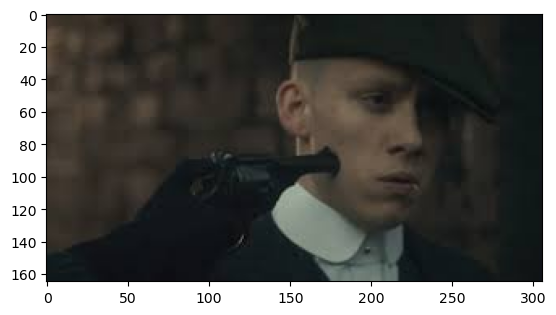

In [274]:
# LOAD THE IMAGE
img = cv2.imread(os.path.join(root,'Images',f'{331}.jpeg'),1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)


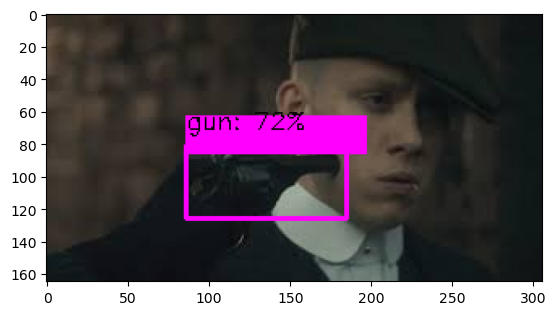

In [275]:
results = yolov5_preditctions(img,net)
plt.imshow(results)
